<a href="https://colab.research.google.com/github/KwonDuHyeon/hanghae99/blob/main/1%EC%A3%BC%EC%B0%A8_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C(%EA%B6%8C%EB%91%90%ED%98%84).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 1주차 기본과제 권두현


## 1. import 부분

In [ ]:
from matplotlib import pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

## 2. Train Test Data set 설정 부분

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train = False,
    transform=transform
)


Files already downloaded and verified


## 3 Train,Test Data Set Shape 확인

In [ ]:
# Train 데이터셋 shape
print(f'Train Dataset 갯수 : {len(trainset)}')
print(f'Train data set shape : {trainset[0][0].shape}, label : {trainset[0][1]}')

# Test 데이터셋 shape
print(f'Test Dataset 갯수 : {len(testset)}')
print(f'Test data set shape : {testset[0][0].shape}, label : {testset[0][1]}')
# class 갯수
print(f'class 갯수 : {len(trainset.classes)}')

Train Dataset 갯수 : 50000
Train data set shape : torch.Size([3, 32, 32]), label : 6
Test Dataset 갯수 : 10000
Test data set shape : torch.Size([3, 32, 32]), label : 3
class 갯수 : 10


## 4 Train, Test data set loader

In [ ]:
batch_size = 256

# train loader
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

# test loader
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

## 5. 첫번째 batch 출력


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


## 6.accuracy plot 함수 추가

In [ ]:
# accuracy 함수
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt


  # Plot 함수
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

## 7. LeakyReLu 변경 Model

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim, num_classes = 10):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, num_classes)

    self.act = nn.LeakyReLU(negative_slope=0.01)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x




##8.lr, accuracy 리스트 설정

In [ ]:
from torch.optim import SGD, Adam
from logging import critical

lr = 0.001

train_acc_sgd = []
test_acc_sgd = []

train_acc_Adam = []
test_acc_Adam = []

train_acc_Adam_sig = []
test_acc_Adam_sig = []

train_acc_Adam_drop_leaky = []
test_acc_Adam_drop_leaky = []


## 9. Model init 부분

In [ ]:
def init_model():
    model = Model(32*32*3, 1024)
    model = model.to('cuda')
    return model

Q. sgd학습 이후 adam을 학습할때 가장 보편화된 초기화 방법이 어떤건지 궁금합니다.

## 10 Train Model

In [ ]:
def train_model(model, optimizer, trainloader, testloader, n_epochs, criterion):
    train_acc = []
    test_acc = []

    for epoch in range(n_epochs):
        total_loss = 0.0
        model.train()
        for data in trainloader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # 정확도 계산
        with torch.no_grad():
            model.eval()
            train_accuracy = accuracy(model, trainloader)
            test_accuracy = accuracy(model, testloader)
            train_acc.append(train_accuracy)
            test_acc.append(test_accuracy)

        print(
            f"Epoch {epoch+1:03d}/{n_epochs} | Loss: {total_loss:.4f} Train Acc: {train_accuracy:.4f} | Test Acc: {test_accuracy:.4f}"
        )

    return train_acc, test_acc

# SGD와 Adam 성능 비교

## 11.SGD 학습

In [ ]:
n_epochs = 50
criterion = nn.CrossEntropyLoss()

model_SGD = init_model()
optimizer_SGD = SGD(model_SGD.parameters(), lr=lr)
train_acc_SGD, test_acc_SGD = train_model(model_SGD, optimizer_SGD, trainloader, testloader, n_epochs, criterion)


Epoch 001/50 | Loss: 449.8786 Train Acc: 0.1595 | Test Acc: 0.1604
Epoch 002/50 | Loss: 446.1211 Train Acc: 0.2097 | Test Acc: 0.2114
Epoch 003/50 | Loss: 442.4224 Train Acc: 0.2344 | Test Acc: 0.2368
Epoch 004/50 | Loss: 438.7173 Train Acc: 0.2427 | Test Acc: 0.2468
Epoch 005/50 | Loss: 434.9146 Train Acc: 0.2484 | Test Acc: 0.2516
Epoch 006/50 | Loss: 431.0222 Train Acc: 0.2517 | Test Acc: 0.2570
Epoch 007/50 | Loss: 427.1625 Train Acc: 0.2550 | Test Acc: 0.2610
Epoch 008/50 | Loss: 423.3464 Train Acc: 0.2587 | Test Acc: 0.2652
Epoch 009/50 | Loss: 419.6230 Train Acc: 0.2627 | Test Acc: 0.2687
Epoch 010/50 | Loss: 416.0619 Train Acc: 0.2662 | Test Acc: 0.2720
Epoch 011/50 | Loss: 412.7011 Train Acc: 0.2699 | Test Acc: 0.2751
Epoch 012/50 | Loss: 409.4340 Train Acc: 0.2747 | Test Acc: 0.2803
Epoch 013/50 | Loss: 406.3587 Train Acc: 0.2809 | Test Acc: 0.2861
Epoch 014/50 | Loss: 403.4325 Train Acc: 0.2858 | Test Acc: 0.2903
Epoch 015/50 | Loss: 400.6307 Train Acc: 0.2908 | Test Acc: 0.

## 12.Adam 학습

In [ ]:
model_Adam = init_model()
optimizer_Adam = Adam(model_Adam.parameters(), lr=lr)
train_acc_Adam, test_acc_Adam = train_model(model_Adam, optimizer_Adam, trainloader, testloader, n_epochs, criterion)

Epoch 001/50 | Loss: 320.7535 Train Acc: 0.4834 | Test Acc: 0.4690
Epoch 002/50 | Loss: 274.7262 Train Acc: 0.5592 | Test Acc: 0.5137
Epoch 003/50 | Loss: 250.4951 Train Acc: 0.5838 | Test Acc: 0.5171
Epoch 004/50 | Loss: 228.9681 Train Acc: 0.6314 | Test Acc: 0.5407
Epoch 005/50 | Loss: 208.3915 Train Acc: 0.6698 | Test Acc: 0.5346
Epoch 006/50 | Loss: 187.9236 Train Acc: 0.7165 | Test Acc: 0.5371
Epoch 007/50 | Loss: 166.7359 Train Acc: 0.7361 | Test Acc: 0.5373
Epoch 008/50 | Loss: 146.3589 Train Acc: 0.7898 | Test Acc: 0.5359
Epoch 009/50 | Loss: 127.5452 Train Acc: 0.8236 | Test Acc: 0.5412
Epoch 010/50 | Loss: 107.7703 Train Acc: 0.8465 | Test Acc: 0.5291
Epoch 011/50 | Loss: 91.6772 Train Acc: 0.8700 | Test Acc: 0.5459
Epoch 012/50 | Loss: 78.5580 Train Acc: 0.8971 | Test Acc: 0.5393
Epoch 013/50 | Loss: 65.6503 Train Acc: 0.8973 | Test Acc: 0.5361
Epoch 014/50 | Loss: 57.1607 Train Acc: 0.9293 | Test Acc: 0.5471
Epoch 015/50 | Loss: 50.5952 Train Acc: 0.9313 | Test Acc: 0.5510


## 13.결과 비교 plt 함수

In [ ]:
def compare_plot(train_acc_sgd, test_acc_sgd, train_acc_adam, test_acc_adam):
    x = np.arange(len(train_acc_sgd))

    plt.figure(figsize=(10, 6))

    # SGD 결과
    plt.plot(x, train_acc_sgd, label='SGD Train Accuracy', linestyle='-', marker='o')
    plt.plot(x, test_acc_sgd, label='SGD Test Accuracy', linestyle='--', marker='x')

    # Adam 결과
    plt.plot(x, train_acc_adam, label='Adam Train Accuracy', linestyle='-', marker='o')
    plt.plot(x, test_acc_adam, label='Adam Test Accuracy', linestyle='--', marker='x')

    # 그래프 설정
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Comparison of SGD and Adam Optimizers')
    plt.legend()
    plt.grid(True)
    plt.show()



## 14 결과 비교 그래프 실행

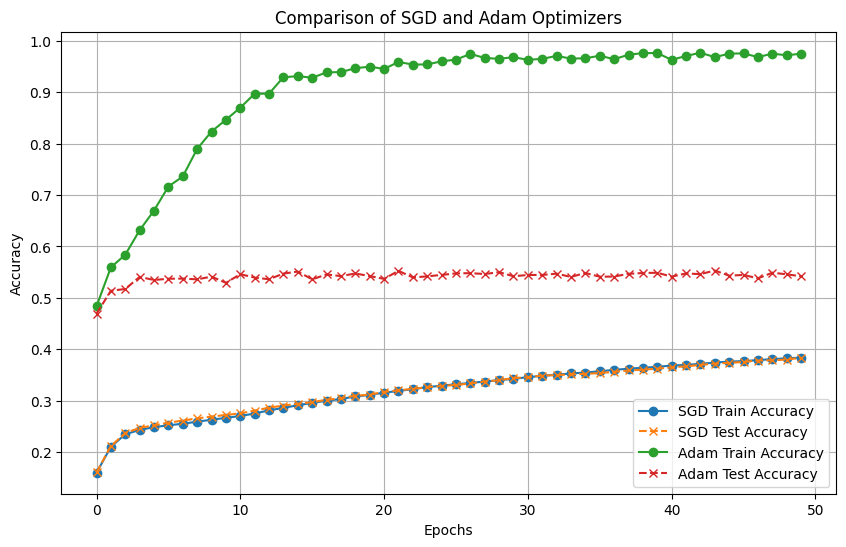

In [ ]:
# 결과 비교 그래프 실행
compare_plot(train_acc_SGD, test_acc_SGD, train_acc_Adam, test_acc_Adam)

# Leaky ReLU와 Sigmoid 성능 비교

## 15.활성화 함수 Sigmoid 변경 모델class



In [ ]:
class Model_Sig(nn.Module):
  def __init__(self, input_dim, n_dim, num_classes = 10):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, num_classes)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x




## 16.Adam을통해 활성화 함수를 sigmoid로 선언된 모델 학습

In [ ]:
model_Adam = Model_Sig(32*32*3, 1024)
model_Adam = model_Adam.to('cuda')
optimizer_Adam = Adam(model_Adam.parameters(), lr=lr)
train_acc_Adam_sig, test_acc_Adam_sig = train_model(model_Adam, optimizer_Adam, trainloader, testloader, n_epochs, criterion)

Epoch 001/50 | Loss: 350.6072 Train Acc: 0.4283 | Test Acc: 0.4194
Epoch 002/50 | Loss: 305.3643 Train Acc: 0.4765 | Test Acc: 0.4554
Epoch 003/50 | Loss: 281.4579 Train Acc: 0.5294 | Test Acc: 0.4933
Epoch 004/50 | Loss: 263.3760 Train Acc: 0.5628 | Test Acc: 0.4982
Epoch 005/50 | Loss: 245.0562 Train Acc: 0.5981 | Test Acc: 0.5144
Epoch 006/50 | Loss: 227.7210 Train Acc: 0.6343 | Test Acc: 0.5124
Epoch 007/50 | Loss: 211.2021 Train Acc: 0.6654 | Test Acc: 0.5201
Epoch 008/50 | Loss: 192.0351 Train Acc: 0.7083 | Test Acc: 0.5186
Epoch 009/50 | Loss: 173.9808 Train Acc: 0.7217 | Test Acc: 0.5150
Epoch 010/50 | Loss: 156.3555 Train Acc: 0.7697 | Test Acc: 0.5186
Epoch 011/50 | Loss: 137.9641 Train Acc: 0.8088 | Test Acc: 0.5194
Epoch 012/50 | Loss: 123.5751 Train Acc: 0.8269 | Test Acc: 0.5114
Epoch 013/50 | Loss: 107.0417 Train Acc: 0.8546 | Test Acc: 0.5159
Epoch 014/50 | Loss: 92.0908 Train Acc: 0.8764 | Test Acc: 0.5148
Epoch 015/50 | Loss: 78.5267 Train Acc: 0.9013 | Test Acc: 0.50

## 17.학습결과 비교 (Adam,Sig vs Adam Leaky Relu)

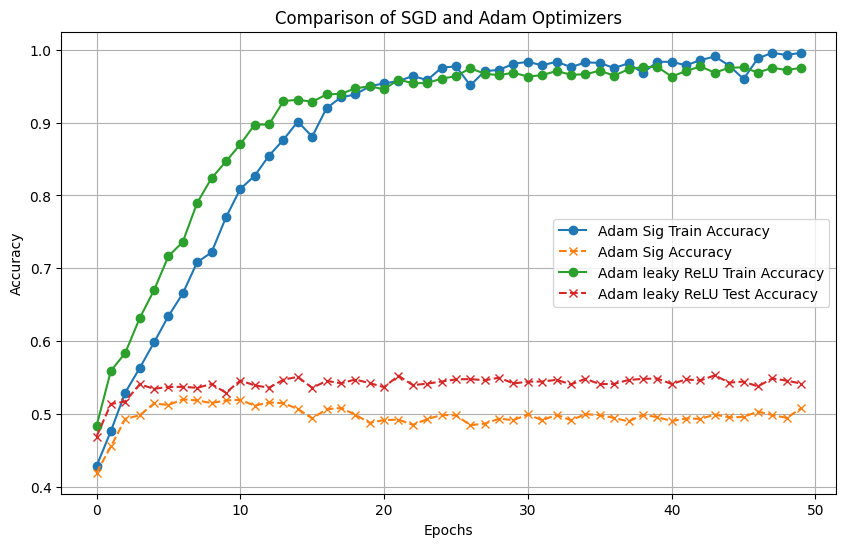

In [ ]:
# 결과 비교
x = np.arange(len(train_acc_Adam_sig))

plt.figure(figsize=(10, 6))

# SGD 결과
plt.plot(x, train_acc_Adam_sig, label='Adam Sig Train Accuracy', linestyle='-', marker='o')
plt.plot(x, test_acc_Adam_sig, label='Adam Sig Accuracy', linestyle='--', marker='x')

# Adam 결과
plt.plot(x, train_acc_Adam, label='Adam leaky ReLU Train Accuracy', linestyle='-', marker='o')
plt.plot(x, test_acc_Adam, label='Adam leaky ReLU Test Accuracy', linestyle='--', marker='x')

# 그래프 설정
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of SGD and Adam Optimizers')
plt.legend()
plt.grid(True)
plt.show()


# Dropout을 적용

## 18.Dropout 적용 클래스

In [ ]:
class Model_drop(nn.Module):
  def __init__(self, input_dim, n_dim, num_classes = 10,  dropout_prob=0.1):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, num_classes)

    self.act = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(p=dropout_prob)
  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.dropout(self.act(self.layer1(x)))  # Dropout 적용
    x = self.dropout(self.act(self.layer2(x)))  # Dropout 적용
    x = self.layer3(x)

    return x




## 19.Adam init

In [ ]:
model_Adam = Model_drop(32*32*3, 1024)
model_Adam = model_Adam.to('cuda')
optimizer_Adam = Adam(model_Adam.parameters(), lr=lr)
train_acc_Adam_drop_leaky, test_acc_Adam_drop_leaky = train_model(model_Adam, optimizer_Adam, trainloader, testloader, n_epochs, criterion)

Epoch 001/50 | Loss: 323.6038 Train Acc: 0.4854 | Test Acc: 0.4676
Epoch 002/50 | Loss: 281.1777 Train Acc: 0.5472 | Test Acc: 0.5040
Epoch 003/50 | Loss: 259.9057 Train Acc: 0.5782 | Test Acc: 0.5160
Epoch 004/50 | Loss: 242.0793 Train Acc: 0.6184 | Test Acc: 0.5397
Epoch 005/50 | Loss: 224.1346 Train Acc: 0.6490 | Test Acc: 0.5399
Epoch 006/50 | Loss: 210.9925 Train Acc: 0.6787 | Test Acc: 0.5422
Epoch 007/50 | Loss: 194.0973 Train Acc: 0.7201 | Test Acc: 0.5462
Epoch 008/50 | Loss: 178.6799 Train Acc: 0.7420 | Test Acc: 0.5486
Epoch 009/50 | Loss: 165.4519 Train Acc: 0.7790 | Test Acc: 0.5623
Epoch 010/50 | Loss: 151.6913 Train Acc: 0.8139 | Test Acc: 0.5536
Epoch 011/50 | Loss: 136.4247 Train Acc: 0.8153 | Test Acc: 0.5459
Epoch 012/50 | Loss: 125.8961 Train Acc: 0.8452 | Test Acc: 0.5556
Epoch 013/50 | Loss: 114.1820 Train Acc: 0.8703 | Test Acc: 0.5494
Epoch 014/50 | Loss: 103.9737 Train Acc: 0.8752 | Test Acc: 0.5507
Epoch 015/50 | Loss: 97.5155 Train Acc: 0.9027 | Test Acc: 0.5

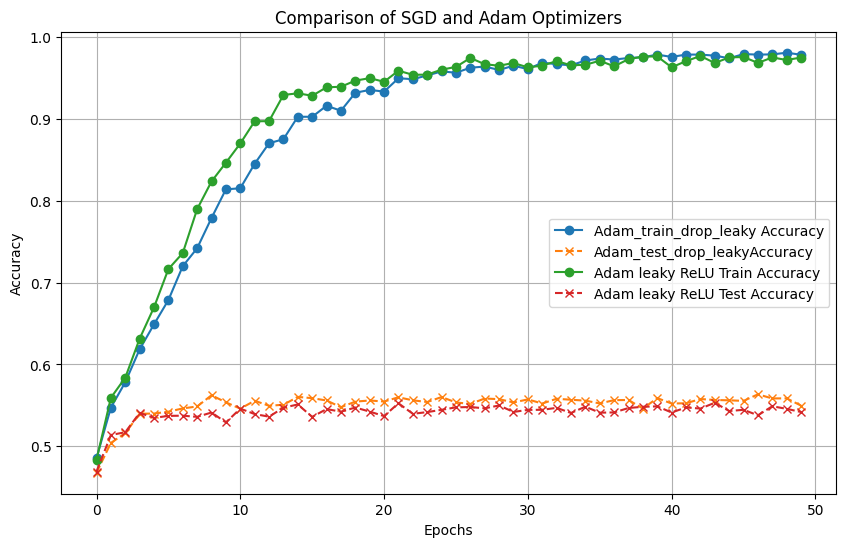

In [ ]:
# 결과 비교
x = np.arange(len(train_acc_Adam_drop_leaky))

plt.figure(figsize=(10, 6))

# SGD 결과
plt.plot(x, train_acc_Adam_drop_leaky, label='Adam_train_drop_leaky Accuracy', linestyle='-', marker='o')
plt.plot(x, test_acc_Adam_drop_leaky, label='Adam_test_drop_leakyAccuracy', linestyle='--', marker='x')

# Adam 결과
plt.plot(x, train_acc_Adam, label='Adam leaky ReLU Train Accuracy', linestyle='-', marker='o')
plt.plot(x, test_acc_Adam, label='Adam leaky ReLU Test Accuracy', linestyle='--', marker='x')

# 그래프 설정
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of SGD and Adam Optimizers')
plt.legend()
plt.grid(True)
plt.show()
